### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from model.lorenz96 import Lorenz96
from model.parameter import Parameter
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

Plotter.fig_folder = "figs_l96"

### Parameters

In [2]:
generator = default_generator
forcing = Parameter(init_value=8, uncertainty=0.2, name="$F$", estimate=False)
n_states = 20

time_step = 0.05
init_time = 0
end_time = 20
ensemble_size = 40

x0_unperturbed = generator.normal(size=n_states)
x0 = x0_unperturbed.copy()
x0[0] += 0

initial_state_covariance = 0.5 * np.eye(n_states)
system_cov = lambda _: 0.5 * np.eye(n_states)
obs_cov = lambda _: 0.3 * np.eye(n_states)

H = lambda _: np.eye(n_states)

### Generate true state

In [3]:
model = Lorenz96(
    x0_unperturbed,
    time_step,
    n_states,
    forcing,
    H,
    system_cov,
    obs_cov,
    generator,
    solver="rk4",
)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_step = 1
assimilation_times = np.linspace(1, end_time, int(end_time / assimilation_step))
observed = np.zeros((n_states, len(assimilation_times)))
observed_true = np.zeros((n_states, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

In [5]:
cut_off_time = 15
model.reset_model(x0)
f = EnKF(model, x0, initial_state_covariance, ensemble_size, generator)
results = f.filter(assimilation_times, observed, cut_off_time=cut_off_time)

# Add true states to compare
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

100%|██████████| 20/20 [00:01<00:00, 11.25it/s]

Localize: False


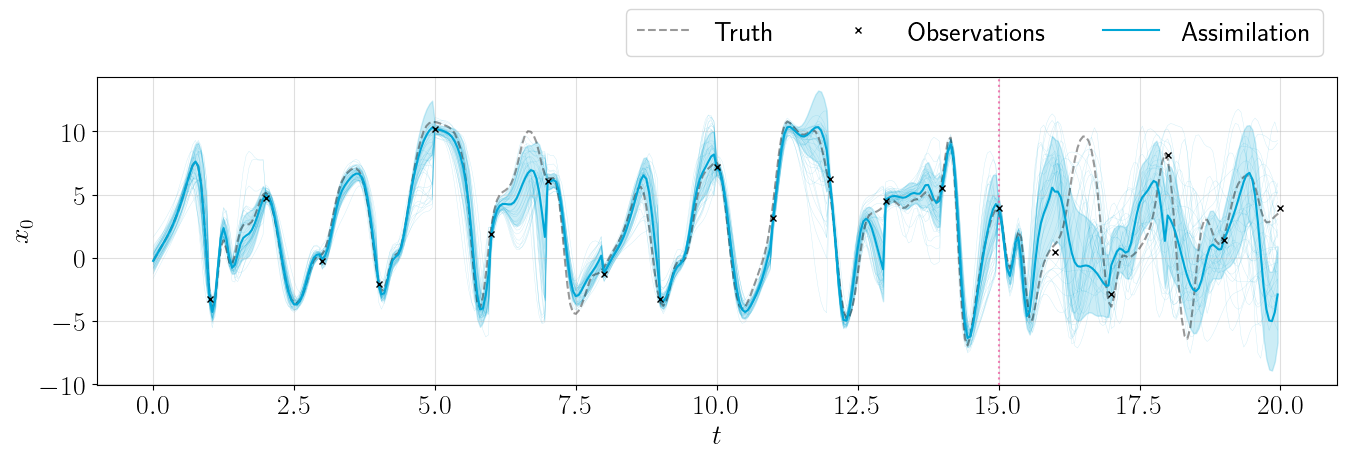

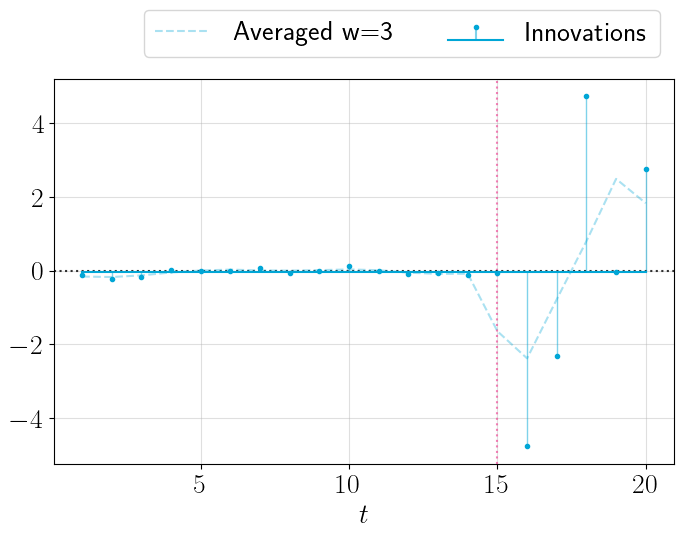

In [6]:
# Plot results
i = 0
results.plot_filtering(i, True, True, path=f"filter_x{i}")
results.plot_innovations(i, window=3, path=f"innovations_x{i}")
plt.show()

### Add a bias function to the model

<Axes: xlabel='$j$', ylabel='$\\beta_j$'>

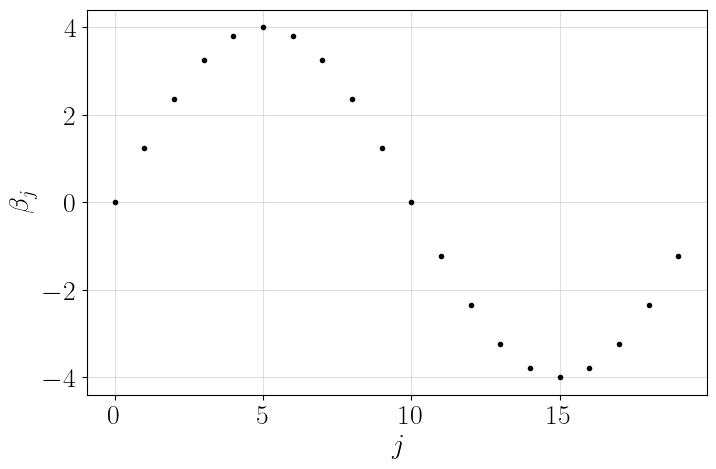

In [7]:
idxs = np.arange(n_states)
a_coeff = 0.5 * forcing.current_value
model.reset_model(x0)
model.offset = lambda t, x: a_coeff * np.sin(2 * np.pi * idxs / n_states)

Plotter.plot(
    idxs,
    model.offset(0, idxs),
    "ko",
    xlabel="$j$",
    ylabel=r"$\beta_j$",
    path="bias.pdf",
)

### EnKF for biased model

In [8]:
cut_off_time = 15
f = EnKF(model, x0, initial_state_covariance, ensemble_size)
results_biased = f.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_biased.true_times = times
results_biased.true_states = states

100%|██████████| 20/20 [00:01<00:00, 10.21it/s]

Localize: False


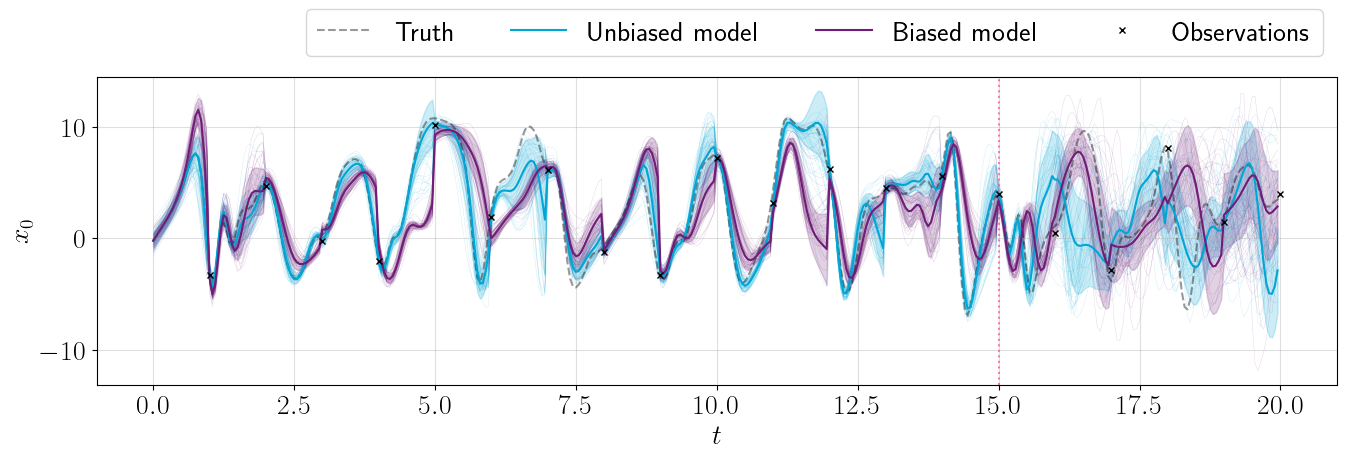

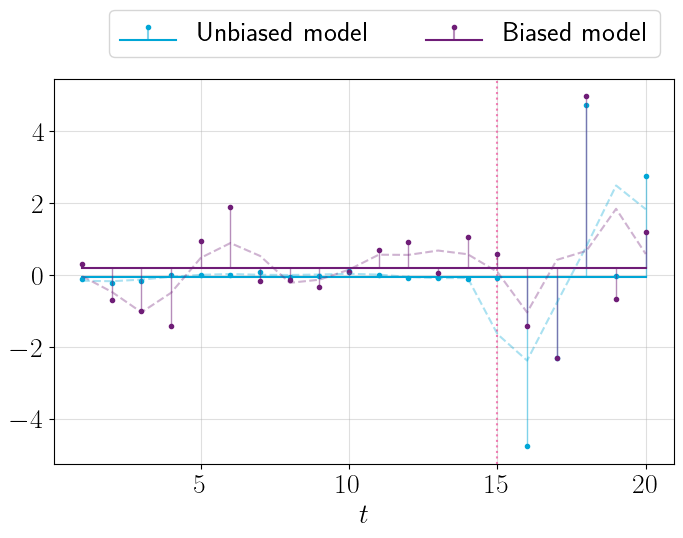

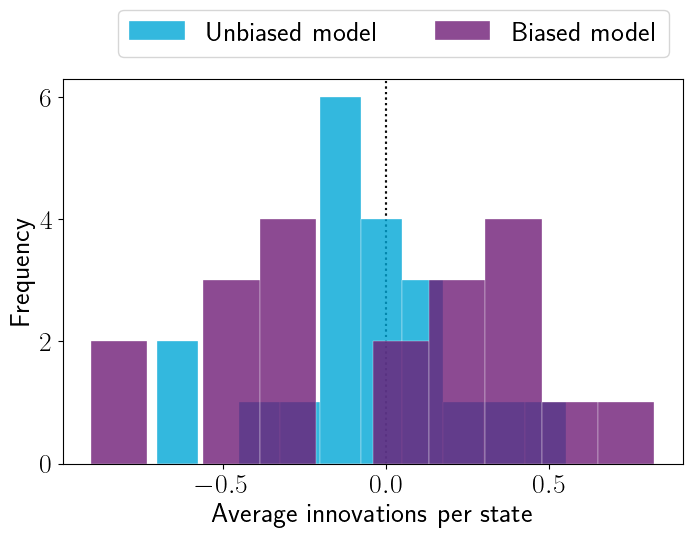

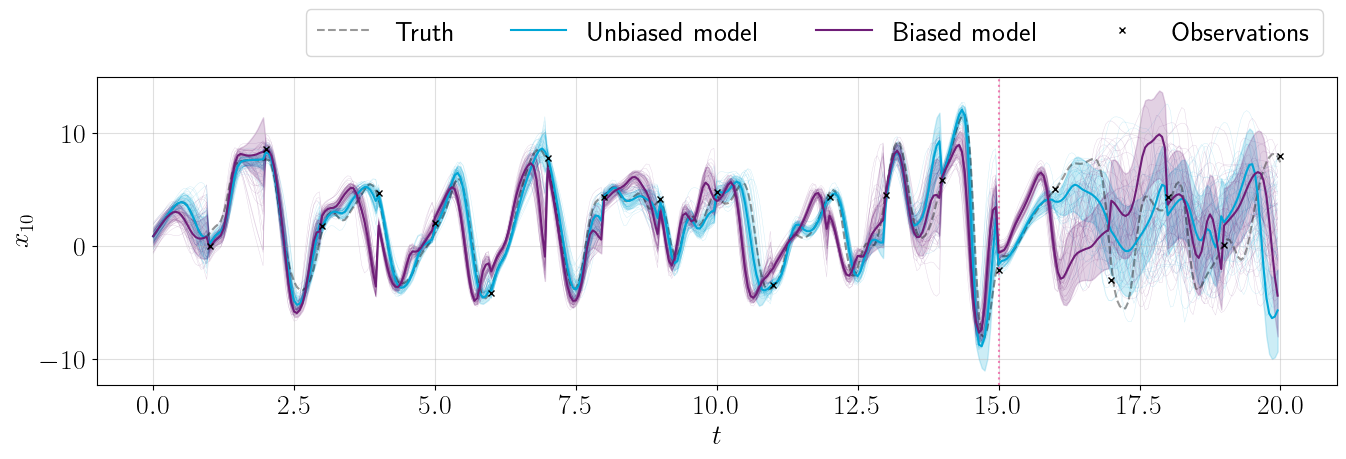

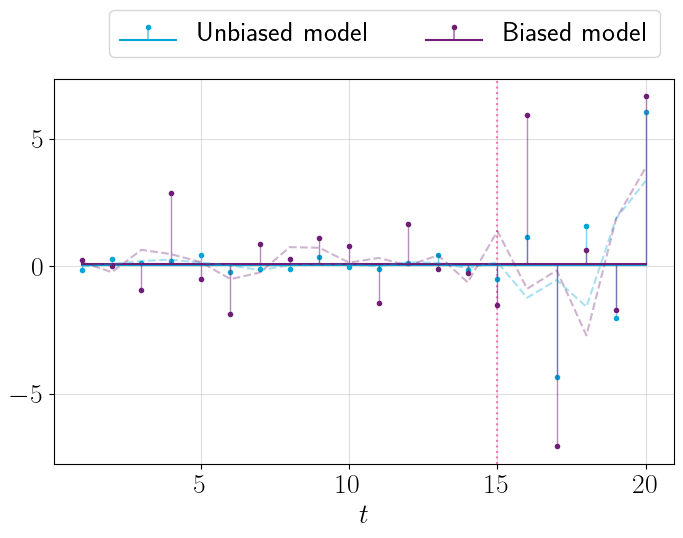

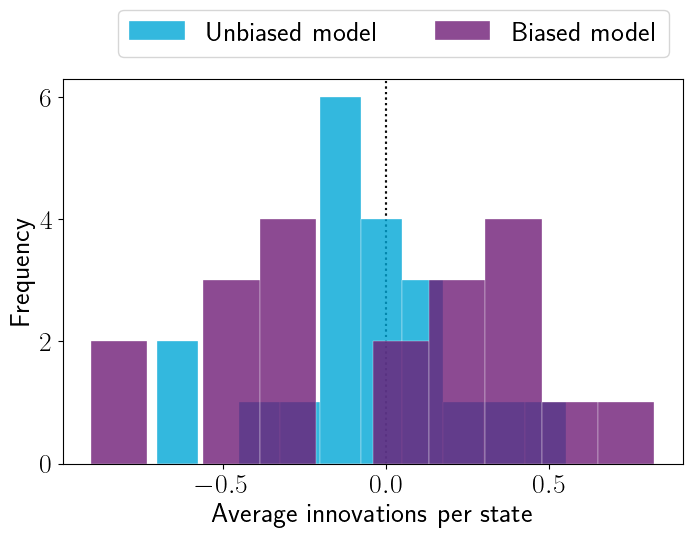

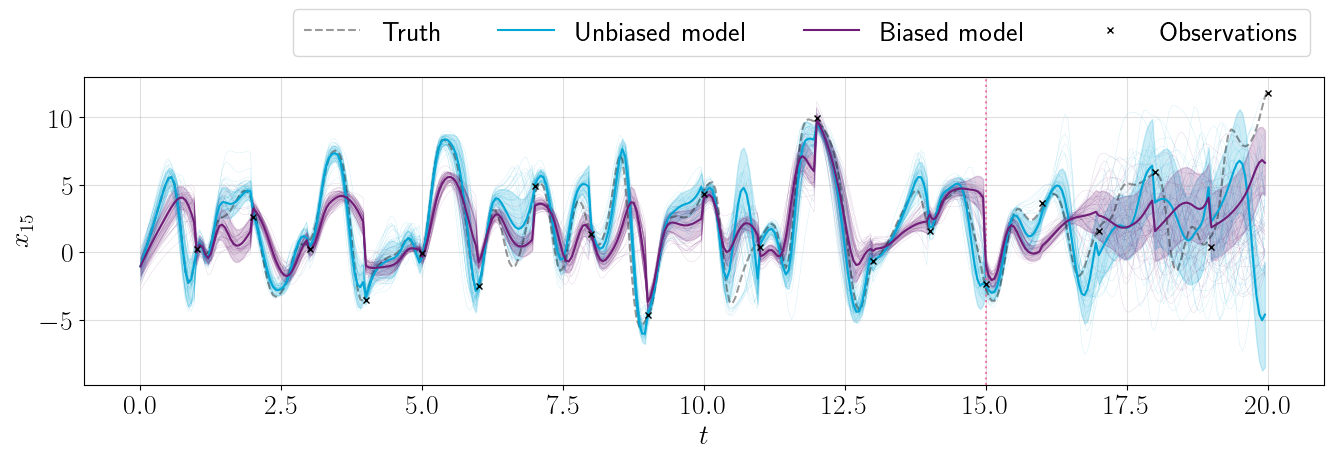

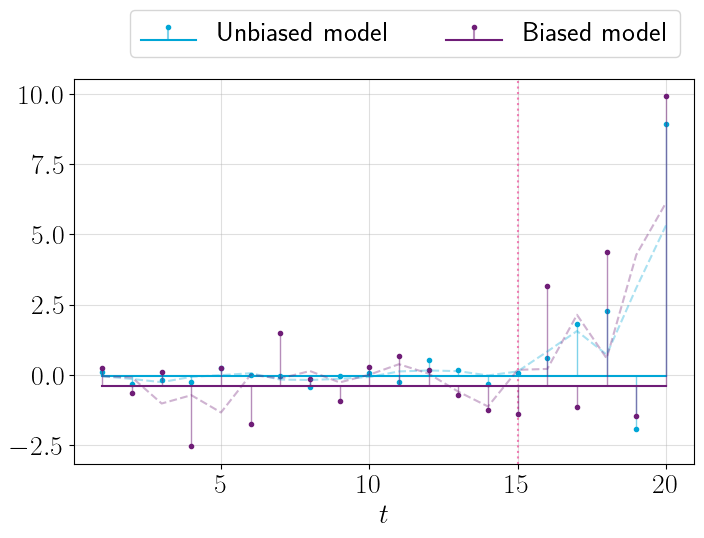

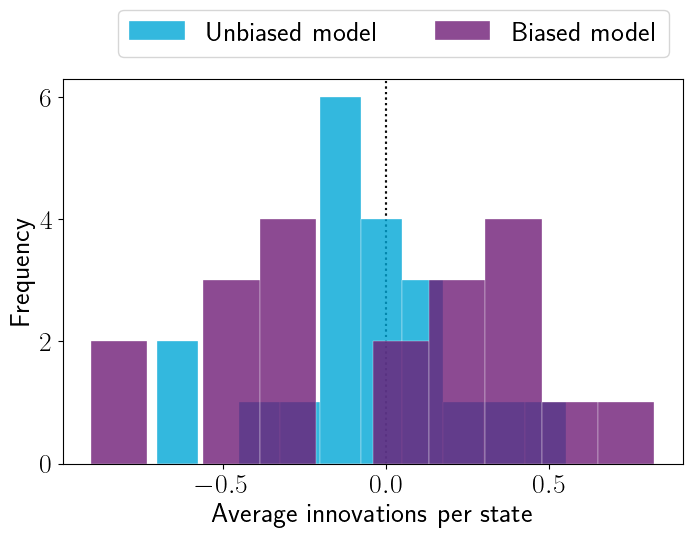

In [10]:
sample = [0, 10, 15]
c = Comparator([results, results_biased], ["Unbiased model", "Biased model"])
for i in sample:
    c.compare_filtering(
        state_idx=i,
        plot_ensemble=True,
        plot_bands=True,
        figsize="horizontal",
        path=f"compare_x{i}",
    )
    c.compare_innovations(
        state_idx=i, figsize="standard", window=3, path=f"compare_inn{i}"
    )
c.compare_av_innovations(path="av_inn", alpha=0.8)
plt.show()